In [1]:
import numpy as np
import pandas as pd
from SWMM import SWMM_ENV as SWMM_ENV
from PPO import PPO as PPO
from DQN import DQN as DQN
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from swmm_api import read_out_file
import os

# Rainfalls

In [2]:
rain1 = np.load('rainfall\\real_rainfall\\rain1.npy').tolist()
rain2 = np.load('rainfall\\real_rainfall\\rain2.npy').tolist()
rain3 = np.load('rainfall\\real_rainfall\\rain3.npy').tolist()
rain4 = np.load('rainfall\\real_rainfall\\rain4.npy').tolist()
raindata={'1':rain1, '2':rain2, '3':rain3, '4':rain4}

# Env

In [3]:
env_params = {
    'orf':'./SWMM/Astlingen_SWMM',
    'orf_save':'Astlingen_RTC',# opt中使用不同的inp计算，上两个参数没有用到
    'parm':'./states_yaml/Astlingen',
    'advance_seconds':300,
    'kf':1,
    'kc':1,
    'reward_type':'3',
}
env3=SWMM_ENV.SWMM_ENV(env_params)

# PPO results

In [4]:
def PPO_interact(model,i,env,raindata):
    observation, episode_return, episode_length = env.reset(raindata,i,False,os.getcwd()), 0, 0
    done, t= False, 0
    while not done:
        observation = np.array(observation).reshape(1, -1)
        logits, action = PPO.sample_action(observation,model,False)
        at=model.action_table[int(action[0].numpy())].tolist()
        observation_new,reward,results,done = env.step(at)
        observation = observation_new
    return env.results

In [5]:
agent_params={
    'state_dim':len(env3.config['states']),
    'action_dim':pd.read_csv('./SWMM/action_table.csv').values[:,1:].shape[0],
    'actornet_layer':[50,50],
    'criticnet_layer':[50,50],
    
    'bound_low':0,
    'bound_high':1,
    
    'clip_ratio':0.01,
    'target_kl':0.03,
    'lam':0.01,
    
    'policy_learning_rate':0.001,
    'value_learning_rate':0.001,
    'train_policy_iterations':20,
    'train_value_iterations':20,
    
    'num_rain':50,
    
    'training_step':1000,
    'gamma':0.3,
    'epsilon':1,
    'ep_min':1e-50,
    'ep_decay':0.1,

    'action_table':pd.read_csv('SWMM/action_table.csv').values[:,1:],
}

model3 = PPO.PPO(agent_params)
model3.load_model('Results_PPO_reward3/model')

In [6]:
# the first 4 rainfalls and real rainfalls, results_PPO_1, results_PPO_2, results_PPO_3
for i in range(91):
    #results_PPO_r1['rainfall'+str(i)] = {}
    #results_PPO_r2['rainfall'+str(i)] = {}
    results_PPO_r3 = PPO_interact(model3,i,env3,raindata)
    np.save('./results/ppo_results_rain'+str(i)+'.npy',results_PPO_r3)

# DQN results

In [7]:
def DQN_interact(model,i,env,raindata):
    observation, episode_return, episode_length = env.reset(raindata,i,False,'.'), 0, 0
    done, t= False, 0
    while not done:
        observation = np.array(observation).reshape(1, -1)
        action = DQN.sample_action(observation,model,False)
        at=model.action_table[int(action[0].numpy())].tolist()
        observation_new,reward,results,done = env.step(at)
        observation = observation_new
    return env.results

In [8]:
agent_params={
    'state_dim':len(env3.config['states']),
    'action_dim':pd.read_csv('./SWMM/action_table.csv').values[:,1:].shape[0],

    'encoding_layer':[50,50],
    'value_layer':[50,50],
    'advantage_layer':[50,50],
    'num_rain':50,


    'train_iterations':10,
    'training_step':500,
    'gamma':0.01,
    'epsilon':0.1,
    'ep_min':1e-50,
    'ep_decay':0.9,
    'learning_rate':0.001,

    'action_table':pd.read_csv('./SWMM/action_table.csv').values[:,1:],
}

#dmodel2 = DQN.DQN(agent_params)   
#dmodel2.load_model('./Results_DQN_reward2/model/')
dmodel3 = DQN.DQN(agent_params)   
dmodel3.load_model('./Results_DQN_reward3/model/')

In [9]:
# the first 4 rainfalls and real rainfalls, results_PPO_1, results_PPO_2, results_PPO_3
for i in range(91):
    #results_DQN_r1['rainfall'+str(i)] = {}
    #results_DQN_r2['rainfall'+str(i)] = {}
    results_DQN_r3 = DQN_interact(dmodel3,i,env3,raindata)
    np.save('./results/dqn_results_rain'+str(i)+'.npy',results_DQN_r3)

# Check results

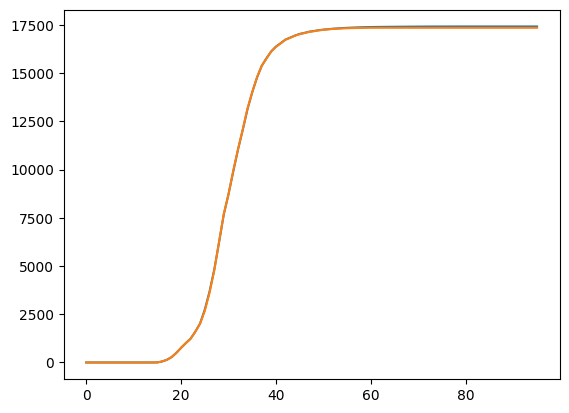

In [10]:
plt.plot(results_DQN_r3['flooding'])
plt.plot(results_PPO_r3['flooding'])